In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from matplotlib.ticker import LogFormatter 
from scipy.optimize import curve_fit
from pathlib import Path
import matplotlib.colors

Для задачи про кривой кубок (стр 54):

In [2]:
# 0 - симметричный кубик
# 1 - кривой кубик

#матрица переходов между скрытыми состояниями:
A =  np.array([[0.95, 0.05], [0.1, 0.9]])
#A =  np.array([[0.5, 0.5], [0.8, 0.2]])

m = A.shape[0] #число скрытых состояний

n = 6 #Вариантов открытых состояний 

#Матрица эмиссий - открытые состояния из скрытых:
B = np.ones((m, n))
B[0, :] = B[0, :]/6
B[1, :] = B[1, :]/10
B[1, 5] = 0.5


#Начальное распределение состояний:
p = np.ones(m)/m


In [3]:
p

array([0.5, 0.5])

In [4]:
def generate_sample(A, B, p0, L=350):
    
    hidden_seq = np.zeros(L, dtype = int)
    open_seq = np.zeros(L, dtype = int)
    
    hidden_seq[0] = np.random.choice(2, p =p0)
    
    open_seq[0] = np.random.choice(6, p =B[hidden_seq[0]])
    for i in range(1, L):
        hidden_seq[i] = np.random.choice(2, p = A[hidden_seq[i-1]])
     
        open_seq[i] =  np.random.choice(6, p =B[hidden_seq[i]])
    
    return hidden_seq, open_seq

In [5]:
hidden_seq, open_seq = generate_sample(A, B, p)
initvalue = hidden_seq[0]
 

In [6]:
def Viterbi(A, B, p0, open_seq):
    
    L = len(open_seq)   
    m = A.shape[0]
    v = np.zeros((m, L))
    ptr = np.zeros((L, m)) #
    
    #Вроде мы знаем начальное распределение типов кубика, а не идет от определенного состояния 
    #v[:, 0] = np.log(p0) + np.log(B[:, open_seq[0]]) 
    v[:, 0] =  np.log(np.multiply(p0, B[:, open_seq[0]]))
    
    for i in range(1, L):
        #вероятность эмиссионная + переход
        v[:,i] = np.log(B[:, open_seq[i]]) + np.max(v[:,i-1].T + np.log(A.T), axis = 1) #check A 
        ptr[i, :] = np.argmax(v[:,i-1].T + np.log(A.T), axis = 1) #check axis 
  
    hidden_seq = np.zeros(L, dtype=int)
    hidden_seq[-1] = np.argmax(v[:, -1])
    for i in range(L - 1, 0, -1):
        hidden_seq[i - 1] = ptr[i, hidden_seq[i]]
    
    return hidden_seq

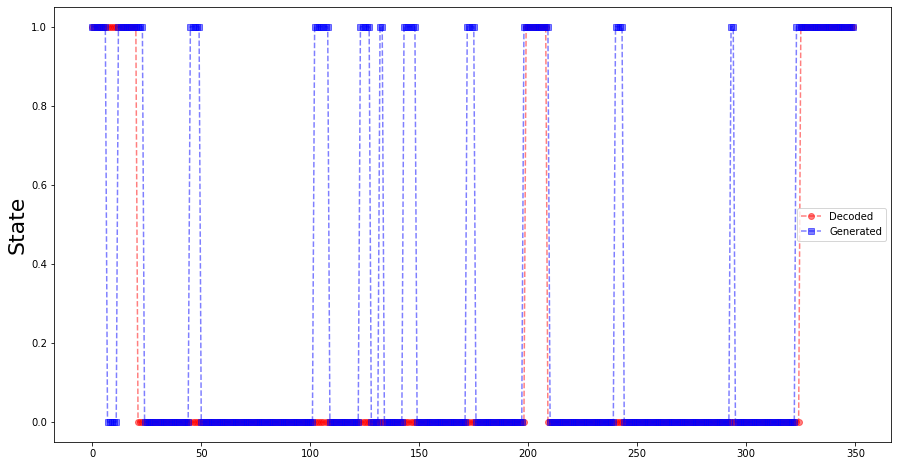

In [7]:
#A =  np.array([[0.8, 0.2], [0.1, 0.9]])
decoded = Viterbi(A, B, p, open_seq)
     
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
 
plt.plot(decoded, "o--", alpha = 0.5, c="r", label =  "Decoded")
plt.plot(hidden_seq, "s--", alpha = 0.5, c = "b", label = "Generated")

plt.ylabel(r"State", fontsize=22)

plt.legend()

In [8]:
def forward(A, B, p0, open_seq):
    m = A.shape[0]
    T = len(open_seq)
    f = np.zeros((T + 1, m))
    f[0, initvalue] = 1#np.log(p0) + np.log(B[:, open_seq[0]])
    #f[0,  open_seq[0] ] = 1
    log_px = 0.
    for t in range(1, T + 1):
        f[t] = B[:,  open_seq[t - 1]] * \
                   np.dot(f[t - 1], A)
        pt = f[t].sum()
        #print(f[t], pt)
        f[t] /= pt
        log_px += np.log(pt)
        #print(log_px)
    return f, log_px
 

In [9]:
def backward(A, B, p0, open_seq):
    T = len(open_seq)
    m = A.shape[0]
    b = np.zeros((T + 1, m))
    b[T, :] = 1
    log_px = 0.
    for t in range(T, 0, -1):
        b[t - 1] = np.dot(A, b[t] * B[:, open_seq[t - 1]])
        pt = b[t - 1].sum()
        b[t - 1] /= pt
        log_px += np.log(pt)
        #print(log_px)
    log_px += np.log(b[0, initvalue])
    return b, log_px    
    
    
    

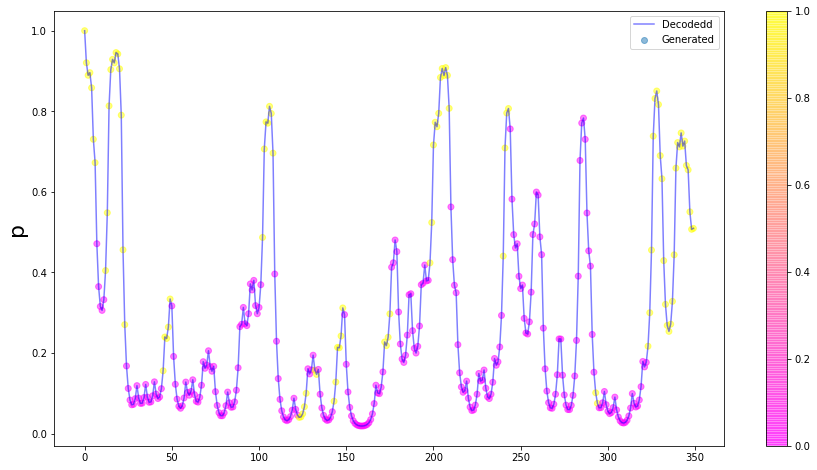

In [10]:
f, fdecoded = forward(A, B, p, open_seq)


b, bdecoded = backward(A, B, p, open_seq)

#post_probs = f[:-1, :] * b[:-1, :] /  np.sum(f[:-1, :] * b[:-1, :] , axis=0, keepdims=True)
 
#print(bdecoded, fdecoded)
        
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
 
#print(len(post_probs[:, 0]), len(hidden_seq))
#plt.scatter(np.arange(len(hidden_seq)),hidden_seq,  alpha = 0.5, c=hidden_seq, label =  "Generated", cmap = "spring")
gamma = f[:-1, :] * b[:-1, :]
gamma /= np.sum(gamma, axis=1, keepdims=True)
plt.scatter(np.arange(len(hidden_seq)), gamma[:,1],  alpha = 0.5, c=hidden_seq, label =  "Generated", cmap = "spring")

plt.plot(np.arange(len(hidden_seq)),gamma [:,1], "-", alpha = 0.5, c = "b", label = "Decodedd")

#plt.xlabel(r' $ \% $', fontsize = 22)
plt.ylabel(r"p", fontsize=22)

plt.legend()

plt.colorbar()

In [12]:
def baum_welch(A, B, p0, seq):
    seq_arr = np.array([int(i) for i in seq])
    T = len(seq_arr)
    n_states = A.shape[0]
    kesi = np.zeros((T + 1, n_states, n_states))
    log_px = None
    iter = 0
    n_emissions = B.shape[1]
    while True:
        iter += 1
        alpha, alpha_log_px = forward(A, B, p0, seq)
        if log_px and (np.abs(
                log_px - alpha_log_px) < np.abs(1e-6 * log_px)):
            break
        beta, beta_log_px = backward(A, B, p0, seq)
 
        log_px = alpha_log_px
        gamma = alpha * beta
        gamma /= np.sum(gamma, axis=1, keepdims=True)
        for t in range(1, T):
            kesi[t] = np.outer(
                alpha[t],
                beta[t + 1] * B[:, seq_arr[t + 1 - 1]]) * A
        kesi[1:T] = kesi[1:T] / kesi[1:T].sum(axis=(1, 2), keepdims=True)
        A = kesi[1:T].sum(axis=0) /  gamma[1:T].sum(axis=0)[:, np.newaxis]
        obs = np.zeros((T + 1, n_emissions))
        obs[range(1, T + 1), seq_arr] = 1
        B = np.dot(gamma[1:].T, obs[1:]) /  gamma[1:].sum(axis=0)[:, np.newaxis]
 
    return log_px, A, B

In [13]:
log_px, A, B = baum_welch(A, B, p,open_seq)


In [14]:
A

array([[0.94187415, 0.05812585],
       [0.31229497, 0.68770503]])

In [15]:
B

array([[1.89432458e-01, 1.13113726e-01, 1.59022462e-01, 1.80203896e-01,
        1.75872790e-01, 1.82354669e-01],
       [2.23979940e-04, 1.94117247e-01, 6.64502373e-07, 1.23791151e-01,
        3.64205587e-04, 6.81502752e-01]])

In [16]:
hidden_seq, open_seq = generate_sample(A, B, p, 3500)
initvalue = hidden_seq[0]

log_px, A, B = baum_welch(A, B, p,open_seq)


In [17]:
A

array([[0.95399884, 0.04600116],
       [0.22404106, 0.77595894]])